# Calculation of detectable Gamma ray burst (GRB) event rate associated with Binary Neutron Star (BNS) mergers.

* This is without considering a particular detectors' sensitivity, but rather a general calculation of the rate of detectable GRBs based of viewing angle and luminosity distance. I have considered the inclination angle gravitational waves same as the viewing angle wrt GRB jet axis.

* For BNS source redshift and mass distribution, refer [here](https://ler.readthedocs.io/en/latest/GW_events.html).

* For lens and image properties, refer [here](https://ler.readthedocs.io/en/latest/Lensed_events.html).


## Equations (GRB)

* Ref: Granot, J. & Kumar, P. (2003). "Distribution of gamma-ray burst ejecta energy with Lorentz factor." The Astrophysical Journal, 591(2), 1086-1096. DOI: 10.1086/375575

* Disclamer: ChatGPT was used, partially, to get the following expression.

* The observed energy of a gamma-ray burst (GRB) as a function of both the angular distance from the jet axis, $\theta$, and the luminosity distance, $D_L$, is given by:

$$E_{\text{obs}}(\theta) = \frac{\epsilon_0}{4\pi D_L^2} \left(\frac{1}{1 + \left(\frac{\theta}{\theta_c}\right)^k}\right)$$

* Here, $E_{\text{obs}}(\theta)$ is the observed energy, $\epsilon_0$ is the energy per unit solid angle at the jet axis, $D_L$ is the luminosity distance, $\theta$ is the veiwing angle wrt the jet axis, $\theta_c$ is the core angle of the jet, and $k$ is the power-law index that determines how quickly the energy decreases with angle.

* I cosidered the core angle of the jet: $\theta_c = 5$ deg. (this might be too much)

* So, probability of detection is given by:

$$P_{det}(\theta,D_L) = \left\{ 
  \begin{array}{ c l }
    1 & \text{if } \theta \le 5 \text{ deg and } D_L \le 46652 \text{ Mpc } (z\sim 5) \\
    1 & \text{if } \frac{\text{a}}{4\pi D_L^2} \left(\frac{1}{1 + \left(\frac{\theta}{5}\right)^{\text{c}}}\right) \ge 1 \\
    0 & \text{otherwise}
  \end{array}
\right.$$

* Coefficients (a and c) are solved by considering conditions 2 and 3 below.,
  1. If angle <= 5 deg, distance <= distance_cut, then $P_{det}$(bool) = 1.
  2. Luminosity(core)/Luminosity(30deg) >= 100; from GW170817.
  3. pdet <1, If angle < 30 deg (at distance=40) or distance < 40 Mpc (at angle<30). This is by considering the GRB from GW170817 is barely detectable, with viewing angle=30 deg and distance=40 Mpc. 


* I have also tried to consider the angular dependence with dipole radiation formula. But, the enenrgy doesn't drop off quick enough in the off-axis viewing angle. So, I have considered the above equation.

In [3]:
from ler.rates import LeR
import numpy as np
import matplotlib.pyplot as plt

## Probability of detection of GRBs

### Finding the coefficients

In [4]:
import numpy as np
from scipy.optimize import fsolve

# to find coefficient c
# consider: Luminosity(core)/Luminosity(30deg) >= 100; from GW170817
def equation(c):
    return (1 / (1 + (5 / 5)**c))/(1 / (1 + (30 / 5)**c)) - 100

c_guess = 3

# Solve the equation
c_solution = fsolve(equation, c_guess)

print(f"c = {c_solution[0]}")

# to find coefficient a
# consider: pdet = 1, If angle = 30 deg (at distance=40). This is by considering the GRB from GW170817 is barely detectable, with viewing angle=30 deg and distance=40 Mpc.
def equation(a):
    c = 2.9542496722537264
    angle = 30
    distance = 40
    return (1 / (1 + (angle / 5)**c))* (40/distance)**2 * a/(4*np.pi) - 1

a_guess = 3

# Solve the equation
a_solution = fsolve(equation, a_guess)

print(f"a = {a_solution[0]}")

c = 2.9542496722537264
a = 2513.274122871834


### Function to calculate the probability of detection

In [22]:
# Find distance_cut
# convert redshift to luminoisty distance
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
z = 5
d_L = cosmo.luminosity_distance(z)
print(f"d_L = {d_L}")

d_L = 46652.22297277721 Mpc


In [23]:
# distance_cut: z ~ 5
def pdet_grb(angle, distance, distance_cut=46652, duty_cycle=0.5, mask_duty_cycle=True, bool=True):
    """
    Function to calculate the probability of detection for a given angle and distance for GRB. Coefficients are based on 2 and 3 the following conditions,

    0. GRB jet, core angle <= 5 deg
    1. If angle <= 5 deg, distance <= distance_cut, then pdet(bool) = 1
    2. Luminosity(core)/Luminosity(30deg) >= 100; from GW170817
    3. pdet <1, If angle < 30 deg (at distance=40) or distance < 40 Mpc (at angle<30). This is by considering the GRB from GW170817 is barely detectable, with viewing angle=30 deg and distance=40 Mpc.

    Parameters
    ----------
    angle : numpy.ndarray
        Angle between the GRB jet and viewing angle in (rad)
    distance : numpy.ndarray
        Distance between the GRB source and the satellite in (Mpc)
    distance_cut : float
        Core angular size of the GRB jet in (rad)
        default is 25422.742 Mpc
    duty_cycle : float
        Duty cycle of detector(s)
        default is 0.5
    bool : bool
        if True, return absolute value of pdet
        if False, return the pdet value as boolean (with duty cycle applied)
    """

    # coefficients, obtained with scipy.optimize fsolve by considering the condition 2,3 listed in docstring
    c = 2.9542496722537264
    a = 2513.274122871834
    jet_angle_cut = 5

    # convert angle to degree
    angle = np.degrees(angle)

    # make sure that the input data is a numpy array
    angle, distance = np.array([angle]).reshape(-1), np.array([distance]).reshape(-1)

    # angle should be less than 90 or equal to 90
    if len(angle[angle > 90]) > 0:
        angle[angle > 90] = angle[angle > 90]%90

    if bool:
        # calculate the probability of detection, absolute value
        pdet = abs((1 / (1 + (angle / jet_angle_cut)**c))* (40/distance)**2 * a/(4*np.pi))

        # find idx of angle <= jet_angle_cut and distance <= distance_cut
        idx = (angle <= jet_angle_cut) & (distance <= distance_cut)
        # apply the condition, condition 1 from docstring
        pdet[idx] = 1

        if mask_duty_cycle:
            # apply the duty cycle
            # sample random numbers from 0 to 1 and check if it is less than the duty cycle
            num_ = np.random.rand(len(angle))
            mask_duty_cycle = num_ > duty_cycle
            pdet[mask_duty_cycle] = 0

        # return the pdet as boolean
        return (pdet>=1).astype(int)
    else:
        # return the probability of detection (absolute value)
        return abs((1 / (1 + (angle / 5)**c))* (40/distance)**2 * a/(4*np.pi))

### test

In [24]:
angle = np.array([1, 1, 30, 90])
angle = np.radians(angle)
distance = np.array([46652, 46653, 40, 40])
print(pdet_grb(angle, distance, mask_duty_cycle=False, bool=True))

[1 0 1 0]


### Pdet condition checks

In [25]:
print("condition 1, pdet(angle=core_angle,distance=distance_cut): ", pdet_grb(angle=np.radians(5), distance=46652, mask_duty_cycle=False, bool=True))

print("condition 2, absolute value pdet(angle=5,distance=40)/pdet(angle=30,distance=40): ", pdet_grb(angle=np.radians(5), distance=40, mask_duty_cycle=False, bool=False)/pdet_grb(angle=np.radians(30), distance=40, mask_duty_cycle=False, bool=False))

print("condition 3")
print("  i) Detectable, pdet(angle=30,distance=40): ", pdet_grb(angle=np.radians(30), distance=40, mask_duty_cycle=False, bool=True))
print("  ii) Not-Detectable, pdet(angle=31,distance=40): ", pdet_grb(angle=np.radians(31), distance=40, mask_duty_cycle=False, bool=True))
print("  iii) Not-Detectable, pdet(angle=30,distance=50): ", pdet_grb(angle=np.radians(30), distance=50, mask_duty_cycle=False, bool=True))

condition 1, pdet(angle=core_angle,distance=distance_cut):  [1]
condition 2, absolute value pdet(angle=5,distance=40)/pdet(angle=30,distance=40):  [100.]
condition 3
  i) Detectable, pdet(angle=30,distance=40):  [1]
  ii) Not-Detectable, pdet(angle=31,distance=40):  [0]
  iii) Not-Detectable, pdet(angle=30,distance=50):  [0]


* let's write out the function so that it can be used in with LeR
* consider 50% duty cycle

In [26]:
from gwsnr.utils import save_json_dict

# let's write out the function so that it can be used in with LeR
def pdet_calculator(gw_param_dict, duty_cycle=0.5, mask_duty_cycle=True, bool=True, output_jsonfile=False):
    """
    Function to calculate the probability of detection for a given angle and distance for GRB. This is based on the following condition

    1. GRB jet, core angle <= 5 deg
    2. If angle <= 5 deg, distance <= distance_cut, then pdet = 1
    3. Luminosity(core)/Luminosity(30deg) > 100, from GW170817 

    Parameters
    ----------
    gw_param_dict : dict
        dictionary containing the parameters for the GW event
    """

    # get the angle and distance from the dictionary
    angle = gw_param_dict['theta_jn']
    distance = gw_param_dict['luminosity_distance']

    # calculate the probability of detection
    pdet = pdet_grb(angle, distance, duty_cycle=duty_cycle, mask_duty_cycle=mask_duty_cycle, bool=bool)
    pdet_net_dict = dict(pdet_net=pdet)

    # Save as JSON file, if output_jsonfile is provided
    if output_jsonfile:
        output_filename = (
            output_jsonfile if isinstance(output_jsonfile, str) else "pdet.json"
        )
        save_json_dict(pdet_net_dict, output_filename)

    # return the pdet
    return pdet_net_dict

In [27]:
# test
gw_param_dict = {'theta_jn': np.radians(np.array([1, 30, 90])), 'luminosity_distance': np.array([2500, 40, 40])}
print(pdet_calculator(gw_param_dict, mask_duty_cycle=False, bool=True))

{'pdet_net': array([1, 1, 0])}


## Rate calculation of GRB with LeR

* initialize LeR with pdet calculator

In [28]:
ler = LeR(
    verbose=False,
    z_max=5,
    pdet_finder=pdet_calculator, 
    event_type='BNS',
    source_priors=dict(source_frame_masses='binary_masses_uniform',),
    source_priors_params=dict(
        source_frame_masses=dict(
            m_min=1,
            m_max=3,
        ),
    ),
)

### Unlensed events

In [58]:
ler.batch_size = 100000
unlensed_param = ler.unlensed_cbc_statistics(size=500000, output_jsonfile='unlensed_param_grb.json', resume=True)

unlensed params will be store in ./ler_data/unlensed_param_grb.json
chosen batch size = 100000 with total size = 500000
There will be 5 batche(s)
resuming from ./ler_data/unlensed_param_grb.json
saving all unlensed_params in ./ler_data/unlensed_param_grb.json...


In [12]:
ler.batch_size = 100000
lensed_param = ler.lensed_cbc_statistics(size=500000, output_jsonfile='lensed_param_grb.json', resume=True);

lensed params will be store in ./ler_data/lensed_param_grb.json
chosen batch size = 100000 with total size = 500000
There will be 5 batche(s)
resuming from ./ler_data/lensed_param_grb.json
saving all lensed_params in ./ler_data/lensed_param_grb.json...


In [21]:
rate_ratio, unlensed_param_detectable, lensed_param_detectable = ler.rate_comparision_with_rate_calculation(
    detectability_condition = "pdet",
    unlensed_param='unlensed_param_grb.json',
    lensed_param='lensed_param_grb.json',
    output_jsonfile_unlensed='unlensed_param_grb_detectable.json',
    output_jsonfile_lensed='lensed_param_grb_detectable.json',
)

getting unlensed_params from json file ./ler_data/unlensed_param_grb.json...
given detectability_condition == 'pdet'
total unlensed rate (yr^-1) (with step function): 2111.4529984829537
number of simulated unlensed detectable events: 10198
number of all simulated unlensed events: 500000
storing detectable unlensed params in ./ler_data/unlensed_param_grb_detectable.json
getting lensed_params from json file ./ler_data/lensed_param_grb.json...
given detectability_condition == 'pdet'
total lensed rate (yr^-1) (with pdet function): 1.9419719559009283
number of simulated lensed detectable events: 4278
number of simulated all lensed events: 500000
storing detectable lensed params in ./ler_data/lensed_param_grb_detectable.json
unlensed_rate (per year): 2111.4529984829537
lensed_rate (per year): 1.9419719559009283
ratio: 1087.272651938683


* we have 2110 GRBs (detectable, un-lensed) per year
* we have 2.11 GRBs (detectable, lensed) per year
* ratio of lensed to un-lensed is 1:1000

### Out of the detected GRB events, how many are detectable in GW.

In [30]:
ler.selecting_n_lensed_detectable_events(
    size=5000, 
    batch_size=200000,
    detectability_condition = "pdet",
    output_jsonfile='n_lensed_detectable_grb.json', meta_data_file='n_lensed_detectable_grb_meta.json', resume=False);

collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


collected number of events =  1903
total number of events =  200000
total lensed rate (yr^-1): 1.6835431084567156


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


collected number of events =  3771
total number of events =  400000
total lensed rate (yr^-1): 1.6680612354152065


  1%|▌                                                       | 1839/200000 [00:03<06:37, 498.15it/s]


KeyboardInterrupt: 

#### for GW detection

In [45]:
from ler.rates import LeR
from ler.utils import get_param_from_json

ler = LeR(
    verbose=False, 
    z_min=0,
    z_max=5,
    event_type='BNS',
    source_priors=dict(source_frame_masses='binary_masses_uniform',),
    source_priors_params=dict(
        source_frame_masses=dict(
            m_min=1,
            m_max=3,
        ),
    ),
)

In [32]:
lensed_param = get_param_from_json('ler_data/n_lensed_detectable_grb.json')

In [33]:
lensed_param.keys()

dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'effective_luminosity_distance', 'effective_geocent_time', 'pdet_net'])

In [34]:
from gwsnr import GWSNR

gwsnr = GWSNR(gwsnr_verbose=False)

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_0.pickle


In [2]:
gwsnr.detector_horizon()

  0%|                                                                         | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


dl_eff 389.5713941459235
optimal_snr_unscaled [32.91841147]


{'L1': array([416.49499405]),
 'H1': array([416.49499405]),
 'V1': array([317.93913748]),
 'net': array([1603.00893141])}

In [13]:
ler.Dl_to_z(np.array([1603]))

array([0.30839511])

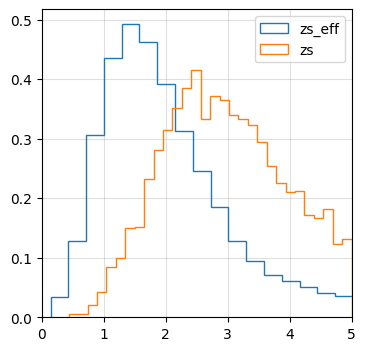

In [44]:
zs_eff = ler.Dl_to_z(lensed_param['effective_luminosity_distance'].flatten())
zs = lensed_param['zs']
plt.figure(figsize=(4, 4))
plt.hist(zs_eff, bins=100, histtype='step', label='zs_eff', density=True)
plt.hist(zs, bins=30, histtype='step', label='zs', density=True)
plt.xlim(0, 5)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [46]:
unlensed_param = ler.unlensed_cbc_statistics(size=50000)

unlensed params will be store in ./ler_data/unlensed_param.json
chosen batch size = 50000 with total size = 50000
There will be 1 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
saving all unlensed_params in ./ler_data/unlensed_param.json...


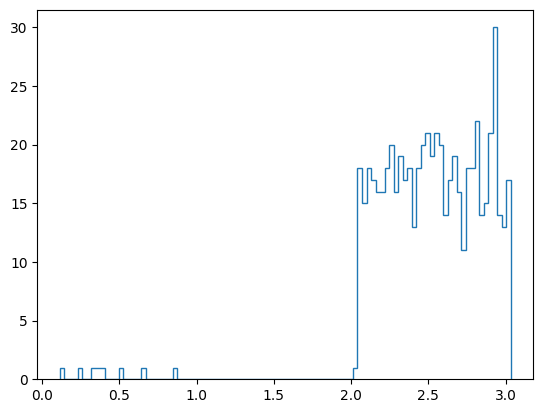

In [74]:
theta_jn = np.degrees(lensed_param['theta_jn'].flatten())
plt.hist(theta_jn%np.pi, bins=100, histtype='step', label='Lensed')
plt.show()

In [35]:
# let's lensed GW snr
snrs, lensed_param = ler.get_lensed_snrs(
    lensed_param=lensed_param,
    list_of_detectors=ler.list_of_detectors,
    snr_calculator=ler.snr,
)

In [36]:
snrs.keys()

dict_keys(['optimal_snr_net', 'L1', 'H1', 'V1'])

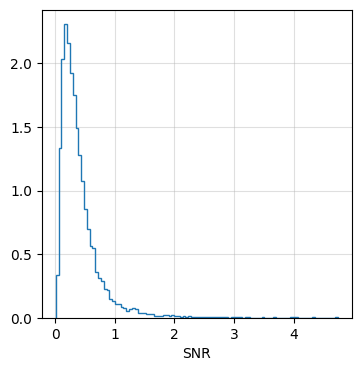

In [47]:
import matplotlib.pyplot as plt

opt_snr = snrs['optimal_snr_net']
idx = (opt_snr > 0) & (opt_snr < 100)
plt.figure(figsize=(4, 4))
plt.hist(opt_snr[idx], bins=100, histtype='step', label='net', density=True)
plt.xlabel('SNR')
plt.grid(alpha=0.4)
plt.show()

In [43]:
lensed_param.update(snrs)

In [44]:
ler.lensed_rate(
    lensed_param=lensed_param,
    snr_threshold=[8.0,8.0],
    num_img=[1,1],
    output_jsonfile='lensed_param_gw_detectable.json',
);

using provided lensed_param dict...
given detectability_condition == 'step_function'
total lensed rate (yr^-1) (with step function): 0.0
number of simulated lensed detectable events: 0
number of simulated all lensed events: 5000
storing detectable lensed params in ./ler_data/lensed_param_gw_detectable.json


## Rate calculation of GW with LeR

* using internal snr_calculator function, with [gwsnr](https://gwsnr.readthedocs.io/en/latest/) package.
* Sensitivity: O4 design sensitivity, [L1,H1,V1]
* for detection criteria of un-lensed BNS GW refer [here](https://ler.readthedocs.io/en/latest/GW_events.html), and for lensed BNS GW refer [here](https://ler.readthedocs.io/en/latest/Lensed_events.html). 

In [48]:
ler = LeR(verbose=False, event_type='BNS')

In [49]:
ler.batch_size = 100000
unlensed_param = ler.unlensed_cbc_statistics(size=500000, output_jsonfile='unlensed_param_bns_gw.json', resume=False);

unlensed params will be store in ./ler_data/unlensed_param_bns_gw.json
chosen batch size = 100000 with total size = 500000
There will be 5 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
Batch no. 2
sampling gw source params...
calculating snrs...
Batch no. 3
sampling gw source params...
calculating snrs...
Batch no. 4
sampling gw source params...
calculating snrs...
Batch no. 5
sampling gw source params...
calculating snrs...
saving all unlensed_params in ./ler_data/unlensed_param_bns_gw.json...


In [50]:
ler.batch_size = 100000
lensed_param = ler.lensed_cbc_statistics(size=500000, output_jsonfile='lensed_param_bns_gw.json', resume=False);

lensed params will be store in ./ler_data/lensed_param_bns_gw.json
chosen batch size = 100000 with total size = 500000
There will be 5 batche(s)
Batch no. 1
sampling lensed params...
solving lens equations...


100%|█████████████████████████████████████████████████████| 100000/100000 [00:25<00:00, 3861.70it/s]


calculating snrs...
Batch no. 2
sampling lensed params...
solving lens equations...


100%|█████████████████████████████████████████████████████| 100000/100000 [00:24<00:00, 4054.86it/s]


Invalid sample found. Resampling 2 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]


calculating snrs...
Batch no. 3
sampling lensed params...
solving lens equations...


100%|█████████████████████████████████████████████████████| 100000/100000 [00:24<00:00, 4052.37it/s]


Invalid sample found. Resampling 2 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


calculating snrs...
Batch no. 4
sampling lensed params...
solving lens equations...


100%|█████████████████████████████████████████████████████| 100000/100000 [00:24<00:00, 4021.48it/s]


Invalid sample found. Resampling 1 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


calculating snrs...
Batch no. 5
sampling lensed params...
solving lens equations...


100%|█████████████████████████████████████████████████████| 100000/100000 [00:24<00:00, 4062.46it/s]


Invalid sample found. Resampling 2 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


calculating snrs...
saving all lensed_params in ./ler_data/lensed_param_bns_gw.json...


In [51]:
rate_ratio, unlensed_param_detectable, lensed_param_detectable = ler.rate_comparision_with_rate_calculation(
    unlensed_param='unlensed_param_bns_gw.json',
    lensed_param='lensed_param_bns_gw.json',
)

getting unlensed_params from json file ./ler_data/unlensed_param_bns_gw.json...
given detectability_condition == 'step_function'
total unlensed rate (yr^-1) (with step function): 2.898641104016606
number of simulated unlensed detectable events: 14
number of all simulated unlensed events: 500000
storing detectable unlensed params in ./ler_data/unlensed_param_detectable.json
getting lensed_params from json file ./ler_data/lensed_param_bns_gw.json...
given detectability_condition == 'step_function'
total lensed rate (yr^-1) (with step function): 0.008448528345568198
number of simulated lensed detectable events: 17
number of simulated all lensed events: 500000
storing detectable lensed params in ./ler_data/lensed_param_detectable.json
unlensed_rate (per year): 2.898641104016606
lensed_rate (per year): 0.008448528345568198
ratio: 343.094203564711


* we have 2.9 GWs (detectable, un-lensed) per year
* we have 0.0084 GWs (detectable, lensed) per year
* ratio of lensed to un-lensed is 1:343

## Final results

### Table for GRB and GW rates

| Event | Unlensed | Lensed | ratio |
| --- | --- | --- | --- |
| GRB | 2110 | 2.11 | 1:1000 |
| GW | 2.9 | 0.0084 | 1:343 |